# Conformal Prediction in Finance

This notebook demonstrates how to apply conformal prediction to financial time series.

## Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

## Simulate Financial Returns

In [2]:
np.random.seed(42)
n = 1000
# simulate price as random walk
prices = np.cumsum(np.random.randn(n)) + 100
returns = np.diff(prices) / prices[:-1]
df = pd.DataFrame({'return': returns})
# create lag features
df['lag1'] = df['return'].shift(1)
df['lag2'] = df['return'].shift(2)
df = df.dropna().reset_index(drop=True)
# split data
train = df.iloc[:600]
calib = df.iloc[600:800]
test = df.iloc[800:]
X_train = train[['lag1','lag2']].values
y_train = train['return'].values
X_calib = calib[['lag1','lag2']].values
y_calib = calib['return'].values
X_test = test[['lag1','lag2']].values
y_test = test['return'].values

## Train Model

In [3]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

## Conformal Calibration

In [4]:
pred_calib = model.predict(X_calib)
errors = np.abs(y_calib - pred_calib)
alpha = 0.1
q = np.quantile(errors, 1 - alpha)
print(f"Calibration quantile (90% interval): {q:.5f}")

Calibration quantile (90% interval): 0.01831


## Prediction Intervals on Test Set

In [5]:
pred_test = model.predict(X_test)
lower = pred_test - q
upper = pred_test + q
# Evaluate coverage
coverage = np.mean((y_test >= lower) & (y_test <= upper))
print(f"Empirical coverage: {coverage*100:.2f}%")

Empirical coverage: 96.95%


## Visualize Predictions and Intervals

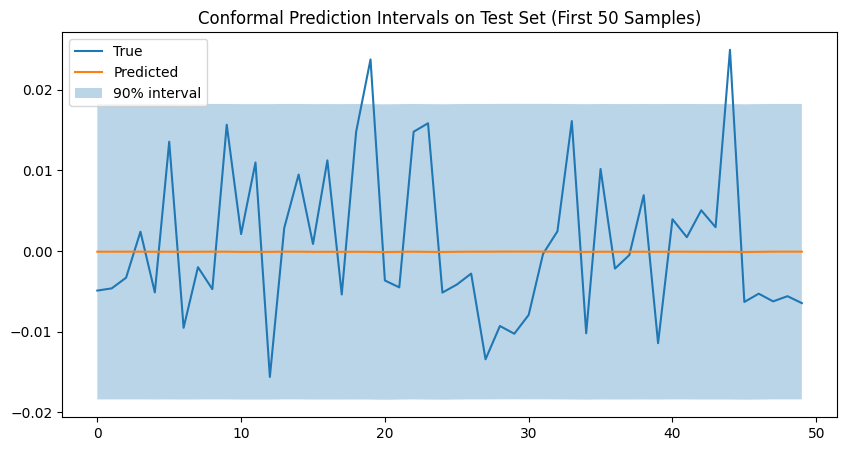

In [6]:
plt.figure(figsize=(10,5))
plt.plot(y_test[:50], label='True')
plt.plot(pred_test[:50], label='Predicted')
plt.fill_between(range(50), lower[:50], upper[:50], alpha=0.3, label='90% interval')
plt.legend()
plt.title('Conformal Prediction Intervals on Test Set (First 50 Samples)')
plt.show()